In [1]:
import tensorflow as tf
import os
import time
os.environ["TF_CPP_MIN_LOG_LEVEL"]= "2"
print("tensorflow Version is: " + str(tf.__version__))

import numpy as np
os.environ['KERAS_BACKEND'] = 'tensorflow'

from keras import backend as K
print(os.environ['KERAS_BACKEND'])

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


tensorflow Version is: 1.14.0
tensorflow


Using TensorFlow backend.


In [2]:
np.random.seed(42)
tf.set_random_seed(42)

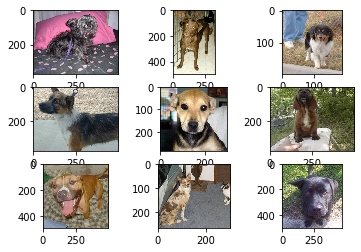

In [5]:
# plot dog photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'dog.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()
display()

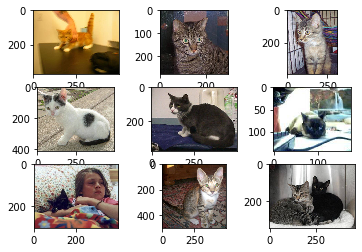

In [4]:
# plot cat photos from the dogs vs cats dataset
from matplotlib import pyplot
from matplotlib.image import imread
# define location of dataset
folder = 'train/'
# plot first few images
for i in range(9):
	# define subplot
	pyplot.subplot(330 + 1 + i)
	# define filename
	filename = folder + 'cat.' + str(i) + '.jpg'
	# load image pixels
	image = imread(filename)
	# plot raw pixel data
	pyplot.imshow(image)
# show the figure
pyplot.show()
display()

In [ ]:
## RUN ONLY ONCE ##

# organize dataset into a useful structure
from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random
# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)
# define ratio of pictures to use for validation
val_ratio = 0.25
# copy training dataset images into subdirectories
src_directory = 'train/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		copyfile(src, dst)

In [6]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
import sys
from matplotlib import pyplot
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.optimizers import SGD
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

In [7]:
# baseline model with data augmentation for the dogs vs cats dataset


# define cnn model
def define_model(model_name='custom'):
    if model_name not in ['custom', 'vgg16', 'resnet50', 'inceptionv3']:
        print('Supported models: custom, vgg16, resnet50, inceptionv3')
        print('Picking inceptionv3 in absence of valid specification')
    if model_name=='custom':
        model = Sequential()
        model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same',
                         input_shape=(224, 224, 3)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(1, activation='sigmoid'))
        # compile model
        opt = 'adam'#SGD(lr=0.001, momentum=0.9)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        return model
    elif model_name=='vgg16':
        # load model
        model = VGG16(include_top=False, input_shape=(224, 224, 3))
        # mark loaded layers as not trainable
        for layer in model.layers:
            layer.trainable = False
        # add new classifier layers
        flat1 = Flatten()(model.layers[-1].output)
        class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
        output = Dense(1, activation='sigmoid')(class1)
        # define new model
        model = Model(inputs=model.inputs, outputs=output)
        # compile model
        opt = 'adam'#SGD(lr=0.001, momentum=0.9)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        return model
    elif model_name=='resnet50':
        # load model
        model = ResNet50(include_top=False, input_shape=(224, 224, 3))
        # mark loaded layers as not trainable
        for layer in model.layers:
            layer.trainable = False
        # add new classifier layers
        flat1 = Flatten()(model.layers[-1].output)
        class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
        output = Dense(1, activation='sigmoid')(class1)
        # define new model
        model = Model(inputs=model.inputs, outputs=output)
        # compile model
        opt = 'adam'#SGD(lr=0.001, momentum=0.9)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        return model
    else:
        # load model
        model = InceptionV3(include_top=False, input_shape=(224, 224, 3))
        # mark loaded layers as not trainable
        for layer in model.layers:
            layer.trainable = False
        # add new classifier layers
        flat1 = Flatten()(model.layers[-1].output)
        class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
        output = Dense(1, activation='sigmoid')(class1)
        # define new model
        model = Model(inputs=model.inputs, outputs=output)
        # compile model
        opt = 'adam'#SGD(lr=0.001, momentum=0.9)
        model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
        return model
    
     

In [8]:
# plot diagnostic learning curves
def summarize_diagnostics(history,name):
    # plot loss
    pyplot.subplot(211)
    pyplot.title('Cross Entropy Loss')
    pyplot.plot(history.history['loss'], color='blue', label='train')
    pyplot.plot(history.history['val_loss'], color='orange', label='test')
    # plot accuracy
    pyplot.subplot(212)
    pyplot.title('Classification Accuracy')
    pyplot.plot(history.history['accuracy'], color='blue', label='train')
    pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
    # save plot to file
    filename = name
    pyplot.savefig(filename + '_plot.png')
    display()
    pyplot.close()

# run the test harness for evaluating a model
def run_test_harness(model_name):
    # define model
    model = define_model(model_name)
    # create data generators
    train_datagen = ImageDataGenerator(
        rescale=1.0/255.0,
        width_shift_range=0.1, 
        height_shift_range=0.1, 
        horizontal_flip=True,
        featurewise_center=True)
    train_datagen.mean=[123.68, 116.779, 103.939]

    test_datagen = ImageDataGenerator(rescale=1.0/255.0,featurewise_center=True)
    test_datagen.mean=[123.68, 116.779, 103.939]

    # prepare iterators
    train_it = train_datagen.flow_from_directory('dataset_dogs_vs_cats/train/',
        class_mode='binary', batch_size=64, target_size=(224, 224))
    test_it = test_datagen.flow_from_directory('dataset_dogs_vs_cats/test/',
        class_mode='binary', batch_size=64, target_size=(224, 224))
    # fit model
    history = model.fit_generator(train_it, steps_per_epoch=len(train_it),
        validation_data=test_it, validation_steps=len(test_it), epochs=50, verbose=1)
    # evaluate model
    _, acc = model.evaluate_generator(test_it, steps=len(test_it), verbose=1)
    print('> %.3f' % (acc * 100.0))
    # learning curves
    summarize_diagnostics(history, model_name)

In [ ]:
# entry point, run the test harness
for name in ['vgg16', 'resnet50', 'inceptionv3']:
    run_test_harness(name)
    

WARNING - From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

WARNING - From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Found 18715 images belonging to 2 classes.
Found 6285 images belonging to 2 classes.


WARNING - From /anaconda/envs/azureml_py36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/50
149/293 [==============>...............] - ETA: 25:40 - loss: 0.8514 - accuracy: 0.5056